In [54]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [55]:
user_profiles = pd.read_csv(r'data/humanized_diet_data.csv')
user_profiles.head()

,age,gender,activity_level,health_conditions,dietary_preferences,diet_goal,meal_frequency,favorite_cuisine,blood_pressure,diet_recommendation
0,34,Male,Moderate,Heart Disease,Low Carb,Health Maintenance,1-2,American,Hypertension Stage 2,Heart-Friendly
1,23,Female,Moderate,Obesity,Keto,Weight Loss,3-4,American,Elevated,Low Carb
2,58,Male,Low,Diabetes,Keto,Muscle Gain,5+,Italian,Normal,Low Carb
3,44,Female,High,NaN,Keto,Health Maintenance,1-2,American,Elevated,Keto
4,65,Female,Low,NaN,Keto,Muscle Gain,3-4,Mexican,Hypertension Stage 2,Low Sodium


In [56]:
# user_profiles.drop("user_id", axis=1, inplace=True)

In [57]:
# user_profiles['height_cm'] = user_profiles['height_cm'].fillna(user_profiles['height_cm'].median())

# user_profiles['weight_kg'] = user_profiles['weight_kg'].fillna(user_profiles['weight_kg'].median())


# user_profiles = user_profiles.dropna(subset=['diet_recommendation'])
# user_profiles['blood_pressure'] = user_profiles["blood_pressure"].fillna(user_profiles["blood_pressure"].mode()[0])

# user_profiles['age'] = user_profiles["age"].fillna(user_profiles["age"].mode()[0])

# user_profiles['allergy_status'] = user_profiles['allergy_status'].fillna('No Allergies')
# user_profiles.isna().sum()

In [58]:
# # Calculate BMI
# user_profiles['BMI'] = (user_profiles['weight_kg'] / ((user_profiles['height_cm'] / 100) ** 2)).round(1)

# # Drop height_cm and weight_kg columns
# user_profiles = user_profiles.drop(['height_cm', 'weight_kg'], axis=1)

# # Checking the first few rows to confirm changes
# user_profiles.head()

In [59]:
# # Split the blood_pressure column into systolic and diastolic values
# user_profiles[['systolic', 'diastolic']] = user_profiles['blood_pressure'].str.split('/', expand=True).astype(float)

# # Fill missing systolic and diastolic values with median if any
# user_profiles['systolic'].fillna(user_profiles['systolic'].median(), inplace=True)
# user_profiles['diastolic'].fillna(user_profiles['diastolic'].median(), inplace=True)

# # Categorize blood pressure based on systolic and diastolic values
# def categorize_blood_pressure(row):
#     if row['systolic'] < 120 and row['diastolic'] < 80:
#         return 'Normal'
#     elif 120 <= row['systolic'] < 130 and row['diastolic'] < 80:
#         return 'Elevated'
#     elif 130 <= row['systolic'] < 140 or 80 <= row['diastolic'] < 90:
#         return 'Hypertension Stage 1'
#     elif row['systolic'] >= 140 or row['diastolic'] >= 90:
#         return 'Hypertension Stage 2'
#     elif row['systolic'] > 180 or row['diastolic'] > 120:
#         return 'Hypertensive Crisis'
#     else:
#         return 'Unknown'

# # Apply categorization function to create a new 'blood_pressure_category' column
# user_profiles['blood_pressure_category'] = user_profiles.apply(categorize_blood_pressure, axis=1)

# # Drop the original blood_pressure column
# user_profiles.drop(columns=['blood_pressure', "systolic", "diastolic"], inplace=True)

# # View the updated dataframe
# user_profiles.head()


In [60]:
x = user_profiles.drop("diet_recommendation", axis=1)
x.head()

,age,gender,activity_level,health_conditions,dietary_preferences,diet_goal,meal_frequency,favorite_cuisine,blood_pressure
0,34,Male,Moderate,Heart Disease,Low Carb,Health Maintenance,1-2,American,Hypertension Stage 2
1,23,Female,Moderate,Obesity,Keto,Weight Loss,3-4,American,Elevated
2,58,Male,Low,Diabetes,Keto,Muscle Gain,5+,Italian,Normal
3,44,Female,High,NaN,Keto,Health Maintenance,1-2,American,Elevated
4,65,Female,Low,NaN,Keto,Muscle Gain,3-4,Mexican,Hypertension Stage 2


In [61]:
y = user_profiles["diet_recommendation"]
y.head()

0    Heart-Friendly
1          Low Carb
2          Low Carb
3              Keto
4        Low Sodium
Name: diet_recommendation, dtype: object

In [62]:
# creating column transformer with 2 types of transformers

numeric_features = x.select_dtypes(exclude="object").columns
categorical_features = x.select_dtypes(include="object").columns


numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, categorical_features),
        ("StandardScaler", numeric_transformer, numeric_features),
    ]
)

In [63]:
x = preprocessor.fit_transform(x)

In [64]:
# train test split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((16000, 34), (4000, 34))

In [65]:
x

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 180000 stored elements and shape (20000, 34)>


Training Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
Accuracy of Logistic Regression: 0.8578
Classification Report for Logistic Regression:
                precision    recall  f1-score   support

      Balanced       0.87      0.74      0.80       343
          DASH       0.18      0.03      0.06        87
Heart-Friendly       1.00      1.00      1.00      1019
          Keto       0.38      0.48      0.43       164
      Low Carb       0.93      0.94      0.94      1321
    Low Sodium       1.00      1.00      1.00       282
 Mediterranean       0.70      0.90      0.79       593
         Paleo       0.13      0.06      0.09        94
         Vegan       0.26      0.09      0.14        97

      accuracy                           0.86      4000
     macro avg       0.61      0.58      0.58      4000
  weighted avg       0.84      0.86      0.84      4000



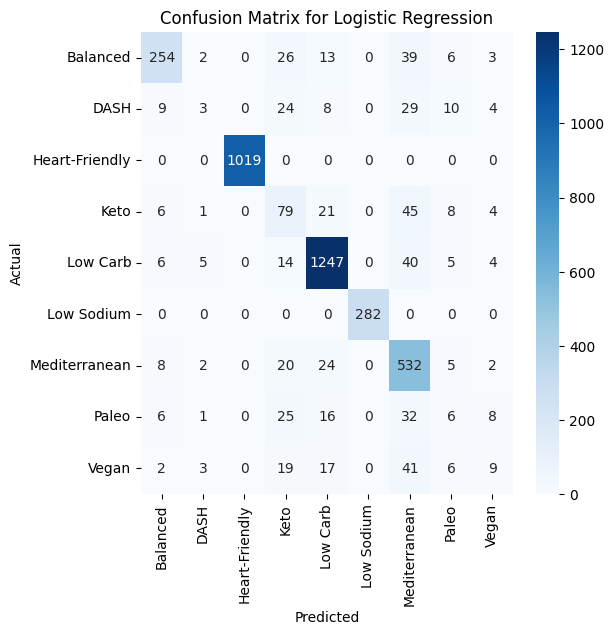


Training Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy of Random Forest: 0.8592
Classification Report for Random Forest:
                precision    recall  f1-score   support

      Balanced       0.74      0.76      0.75       343
          DASH       0.08      0.06      0.07        87
Heart-Friendly       1.00      1.00      1.00      1019
          Keto       0.64      0.46      0.54       164
      Low Carb       0.93      0.94      0.93      1321
    Low Sodium       1.00      1.00      1.00       282
 Mediterranean       0.78      0.89      0.84       593
         Paleo       0.15      0.13      0.14        94
         Vegan       0.14      0.10      0.12        97

      accuracy                           0.86      4000
     macro avg       0.61      0.59      0.60      4000
  weighted avg       0.85      0.86      0.85      4000



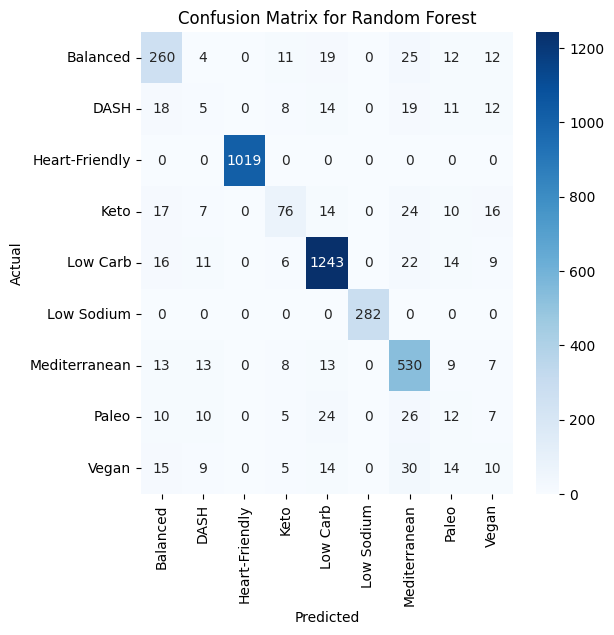


Training Support Vector Classifier...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for Support Vector Classifier: {'C': 1, 'kernel': 'rbf'}
Accuracy of Support Vector Classifier: 0.8628
Classification Report for Support Vector Classifier:
                precision    recall  f1-score   support

      Balanced       0.77      0.78      0.78       343
          DASH       0.17      0.06      0.09        87
Heart-Friendly       1.00      1.00      1.00      1019
          Keto       0.77      0.44      0.56       164
      Low Carb       0.93      0.94      0.94      1321
    Low Sodium       1.00      1.00      1.00       282
 Mediterranean       0.72      0.91      0.80       593
         Paleo       0.13      0.09      0.10        94
         Vegan       0.18      0.16      0.17        97

      accuracy                           0.86      4000
     macro avg       0.63      0.60      0.60      4000
  weighted avg       0.85      0.86      0.85      4000

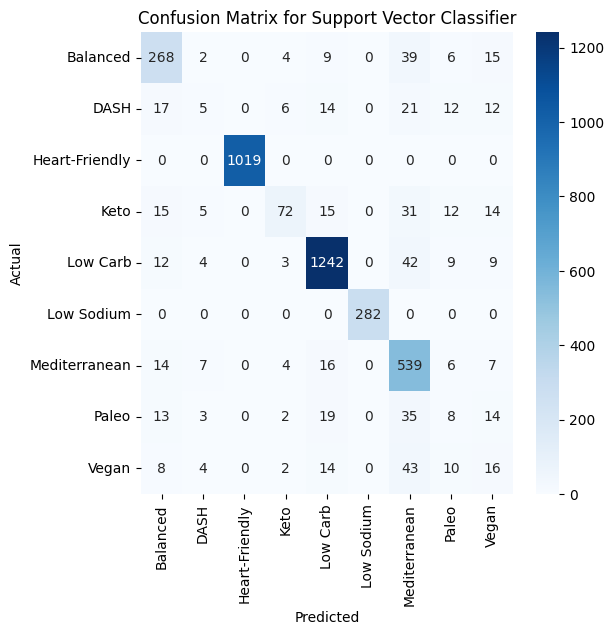


Training K-Nearest Neighbors...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\jayas\OneDrive\Documents\diet_recomendation\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.78862525 0.79800029 0.81256282 0.81887542 0.82512511 0.82968778
 0.83543767 0.83743776        nan 0.79556271        nan 0.81531281
        nan 0.82143776        nan 0.82968772]
  warnings.warn(


Best parameters for K-Nearest Neighbors: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy of K-Nearest Neighbors: 0.8315
Classification Report for K-Nearest Neighbors:
                precision    recall  f1-score   support

      Balanced       0.72      0.72      0.72       343
          DASH       0.05      0.03      0.04        87
Heart-Friendly       1.00      1.00      1.00      1019
          Keto       0.57      0.40      0.47       164
      Low Carb       0.88      0.94      0.91      1321
    Low Sodium       0.99      0.99      0.99       282
 Mediterranean       0.72      0.78      0.75       593
         Paleo       0.13      0.09      0.10        94
         Vegan       0.07      0.05      0.06        97

      accuracy                           0.83      4000
     macro avg       0.57      0.56      0.56      4000
  weighted avg       0.81      0.83      0.82      4000



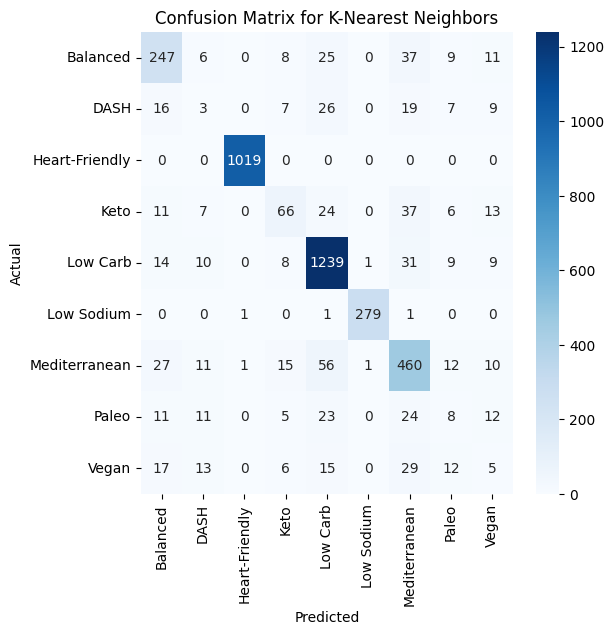

In [66]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier



# Define models and their parameter grids
models = {
    "Logistic Regression": {
        "model": LogisticRegression(),
        "param_grid": {
            "C": [0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Support Vector Classifier": {
        "model": SVC(),
        "param_grid": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    }
}

# Train, tune, and evaluate each model
for model_name, model_info in models.items():
    print(f"\nTraining {model_name}...")

    # Grid search for hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model_info["model"],
        param_grid=model_info["param_grid"],
        cv=3,
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(x_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Predictions
    y_pred = best_model.predict(x_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Accuracy of {model_name}: {accuracy:.4f}")

    # Classification report
    print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}")

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
